# Preprocess Collected WiFi CSI Data

**CSI**: For every images, there are shape of each csi is (6, 8100). where 6 represents the number of packets received during that frame, and 8100 represents 4 antennas * 2025 subcarriers

In [2]:
# Utilities
import os
import glob
import re
# visualize and array
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# filter lib
from scipy.signal import butter, filtfilt
from math import *
import pywt

## 1. Check null value

Single frame

In [2]:
def chck_nan(data):
    nan_values = np.isnan(data).any()
    nan_count = np.sum(np.isnan(data))

    print(nan_values, nan_count)

In [3]:
# Load single frame of Wi-Fi CSI
g1a1_f1 = np.load('../multi-person-data/CSI/G1/A1/frame188.npy')
print(g1a1_f1.shape)

# Check for NaN values
chck_nan(g1a1_f1)

(6, 8100)
False 0


(4, 2025, 6)


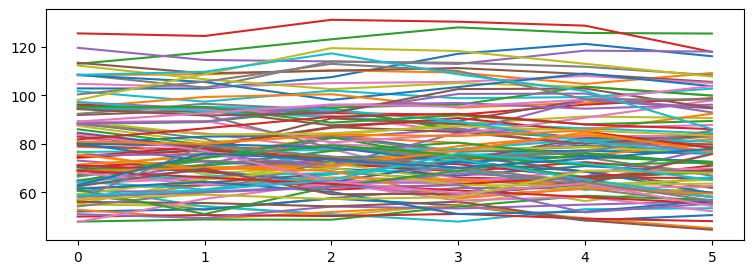

In [4]:
# visualization
# reshape to (tr-pair, #subcarrier, packet)
g1a1_f1 = g1a1_f1.reshape(4,2025,-1)
print(g1a1_f1.shape) # (4, 2025, 6)

# create subplots for environment data for all datasets
plt.figure(figsize=(9, 3))
plt.plot(g1a1_f1[0, :100].T) # first 100-subcarriers
plt.show()

One sequence

In [3]:
# load 1 action of wifi csi data
def load_data(path):
    data = []
    for file in os.listdir(path):
        a = np.load(os.path.join(path, file), allow_pickle=True).reshape(4,2025,-1).T
        data.append(a)
    data = np.vstack(data).T
    return data

In [64]:
g1a1 = load_data('../multi-person-data/CSI/G1/A1')
g1a1.shape

(4, 2025, 3384)

In [65]:
g3a2 = load_data('../multi-person-data/CSI/G3/A2')
g3a2.shape

(4, 2025, 3366)

In [8]:
chck_nan(g1a1)
chck_nan(g3a2)

True 32767
True 31763


Check subcarrier that contains NaN values

In [9]:
def nan_detect(data):
    for tx in range(data.shape[0]):
        subs = []
        for sub in range(data.shape[1]):
            if np.sum(np.isnan(data[tx][sub])) != 0:
                subs.append(f"{sub+1}")
        print(f'NaN values detected: tx#{tx+1}sub#{subs}')

In [10]:
# check NaN value by subcarriers
nan_detect(g1a1)


NaN values detected: tx#1sub#['1346', '1347', '1348', '1349', '1350']
NaN values detected: tx#2sub#['671', '672', '673', '674', '675', '2021', '2022', '2023', '2024', '2025']
NaN values detected: tx#3sub#['1346', '1347', '1348', '1349', '1350']
NaN values detected: tx#4sub#['671', '672', '673', '674', '675', '2021', '2022', '2023', '2024', '2025']


In [11]:
nan_detect(g3a2)

NaN values detected: tx#1sub#['1346', '1347', '1348', '1349', '1350']
NaN values detected: tx#2sub#['671', '672', '673', '674', '675', '2021', '2022', '2023', '2024', '2025']
NaN values detected: tx#3sub#['1346', '1347', '1348', '1349', '1350']
NaN values detected: tx#4sub#['671', '672', '673', '674', '675', '2021', '2022', '2023', '2024', '2025']


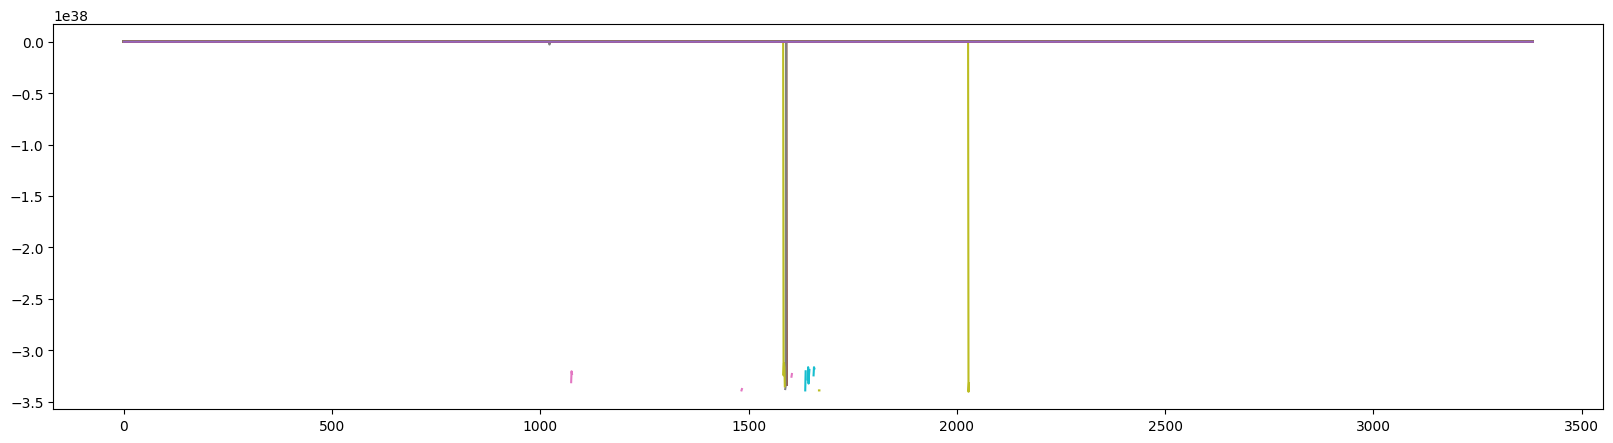

In [236]:
# Whole sequence
plt.figure(figsize=(20, 5))
plt.plot(g1a1[0].T) 
plt.show()

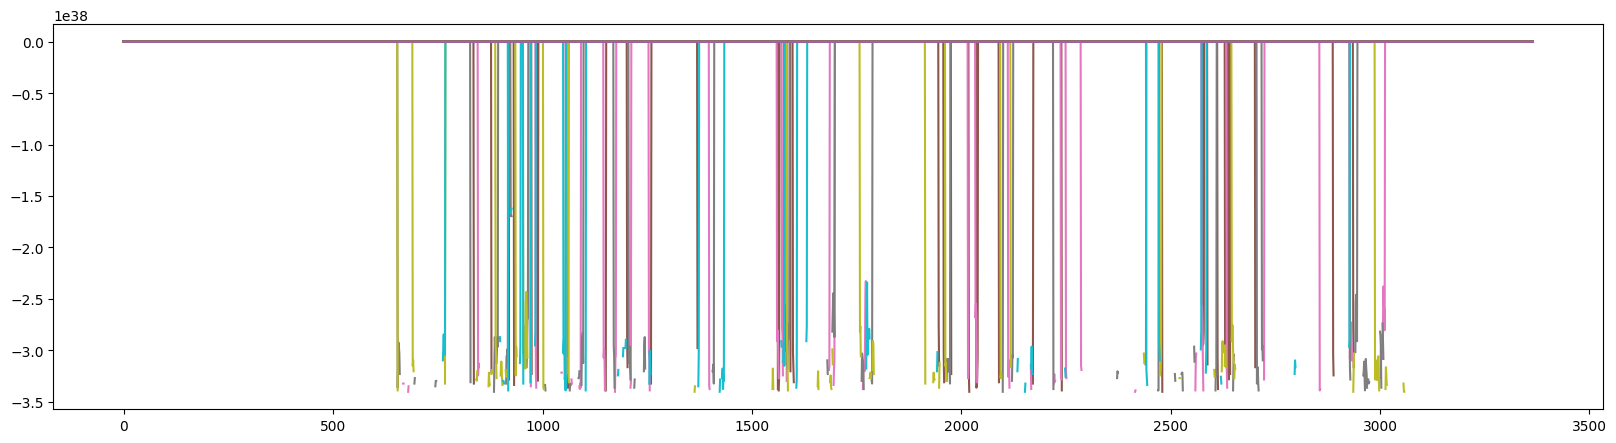

In [240]:
plt.figure(figsize=(20, 5))
plt.plot(g3a2[0].T) 
plt.show()

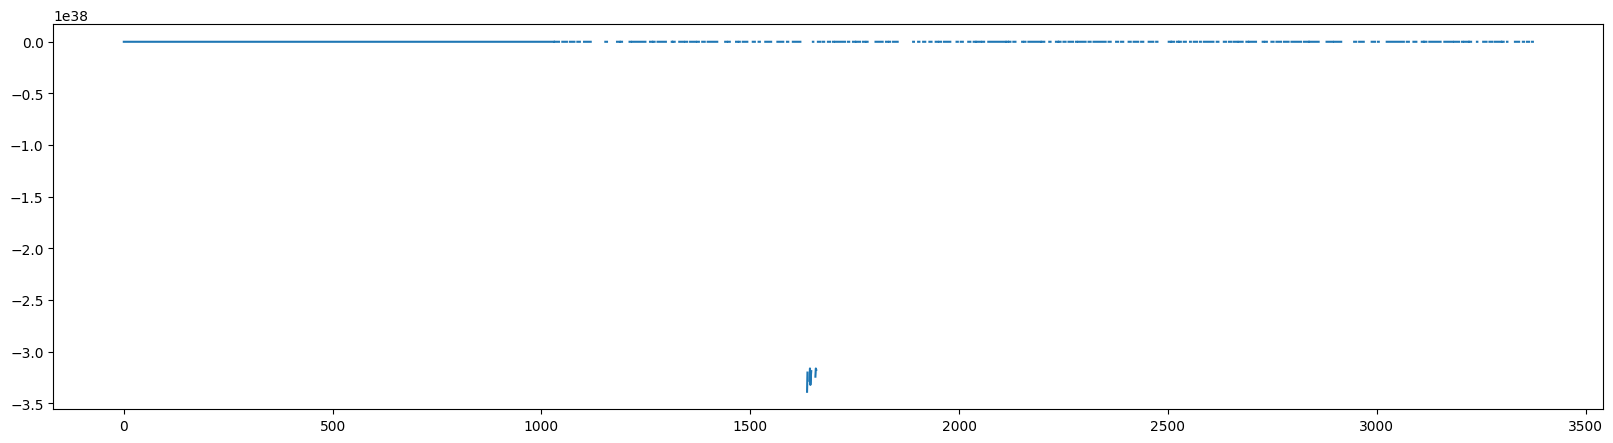

In [232]:
# Visualize subcarrier which contains NaN values
plt.figure(figsize=(20, 5))
plt.plot(g1a1[0, 1349].T) 
plt.show()

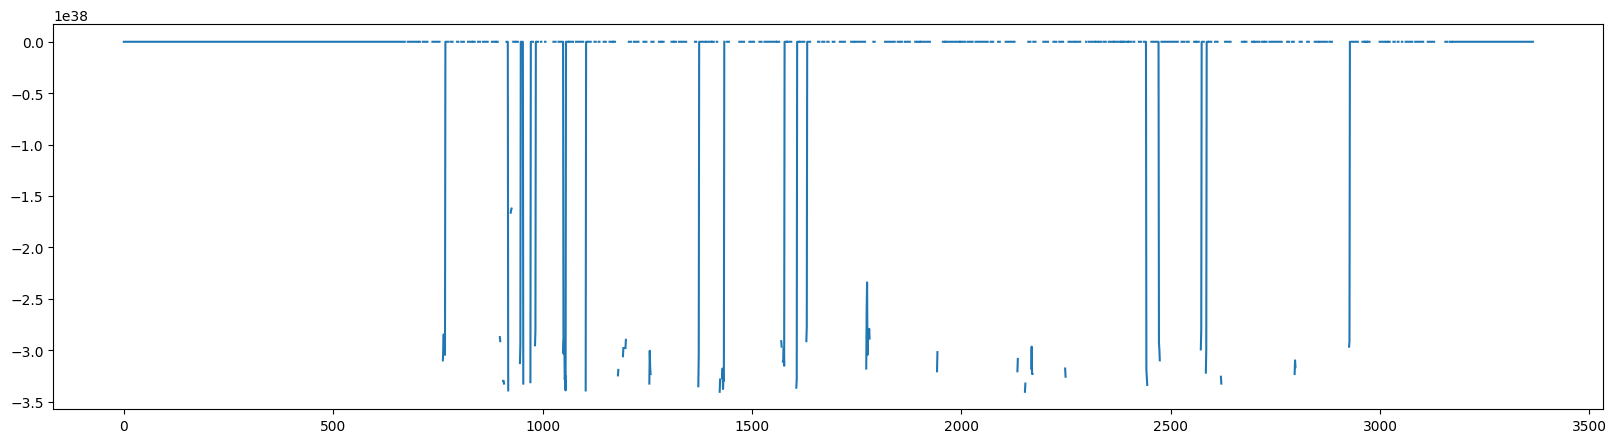

In [241]:
plt.figure(figsize=(20, 5))
plt.plot(g3a2[0, 1349].T) 
plt.show()

## 2. Subcarrier Selection

In [8]:
def load_data(path):
    data = []
    for file in os.listdir(path):
        a = np.load(os.path.join(path, file), allow_pickle=True).reshape(4,2025,-1).T
        data.append(a)
    data = np.vstack(data).T
    # remove nan subcarriers
    nan_subcarriers = np.any(np.isnan(data), axis=(0, 2))
    data = data[:, ~nan_subcarriers, :]
    return data

Too much data. We filter top subcarriers based on Signal-to-Noise Ratio. To calculate the SNR, we follow these steps:
1. **Calculate the power of the signal**:

The power of the signal is calculated as the mean of the squared amplitude values:

$$
P_{signal} = \frac{1}{N} \sum_{i=1}^N{|{s_i}|^2 }
$$

2. **Calculate the power of the noise**:

Assuming the noise is the difference from the mean, the power of the noise is calculated as the mean of the squared differences between the amplitude and its mean:

$$
P_{noise} = \frac{1}{N} \sum_{i=1}^N{|{s_i}-{\mu_i}|^2 }
$$

3. **Calculate the SNR**:

The SNR is calculated as 10 times the logarithm (base 10) of the ratio of the signal power to the noise power:

$$
SNR = 10\log_{10} \frac{P_{signal}}{P_{noise}}
$$

In [ ]:
# Signal-Noise Ration (SNR) select subcarriers which computed independently per subcarrier for the task of subcarrier selection
def compute_snr(csi_data):
    """
    Computes the SNR for each subcarrier across antennas and frames.
    
    Parameters:
        csi_data (np.ndarray): CSI data of shape [antennas, subcarriers, frames].
        
    Returns:
        np.ndarray: SNR for each subcarrier [antennas, subcarriers].
    """
    # Compute signal power per subcarrier
    signal_power = np.mean(np.abs(csi_data) ** 2, axis=2)  # Mean over frames
    # Compute noise power estimation
    noise_power_est = np.var(np.abs(csi_data), axis=2).mean()
    # Compute SNR
    snr = 10 * np.log10(signal_power / noise_power_est)
    return snr

def select_subcarriers(csi_data, top_n):
    """
    Select subcarriers based on SNR values and extract their corresponding CSI data.
    
    Parameters:
        csi_data (np.ndarray): CSI data of shape [antennas, subcarriers, frames].
        top_n (int): Number of top subcarriers to select.
    
    Returns:
        np.ndarray: CSI data of shape [antennas, top_sub, frames].
    """
    # Compute SNR for all subcarriers
    snr = compute_snr(csi_data)

    selected_subcarriers = []

    for antenna_snr in snr:
        # Top-N subcarriers selection
        indices = np.argsort(antenna_snr)[-top_n:]
        selected_subcarriers.append(indices)
    
    selected_subcarriers = np.array(selected_subcarriers)  # Shape: [antennas, top_n]

    # Extract CSI data for selected subcarriers
    selected_csi_data = []
    for i, indices in enumerate(selected_subcarriers):
        # Extract the CSI data for the selected subcarriers
        selected_csi_data.append(csi_data[i, indices, :])
    
    # Stack the results into the required shape [4, top_sub, 6*564]
    selected_csi_data = np.array(selected_csi_data)  # Shape: [antennas, top_sub, frames]

    return selected_csi_data

In [9]:
g1a1 = load_data('../multi-person-data/CSI/G1/A1')
print("Filtering top 30 subcarriers based on SNR...")
g1a1 = select_subcarriers(g1a1, 30)
g1a1.shape

Filtering top 30 subcarriers based on SNR...


(4, 30, 3384)

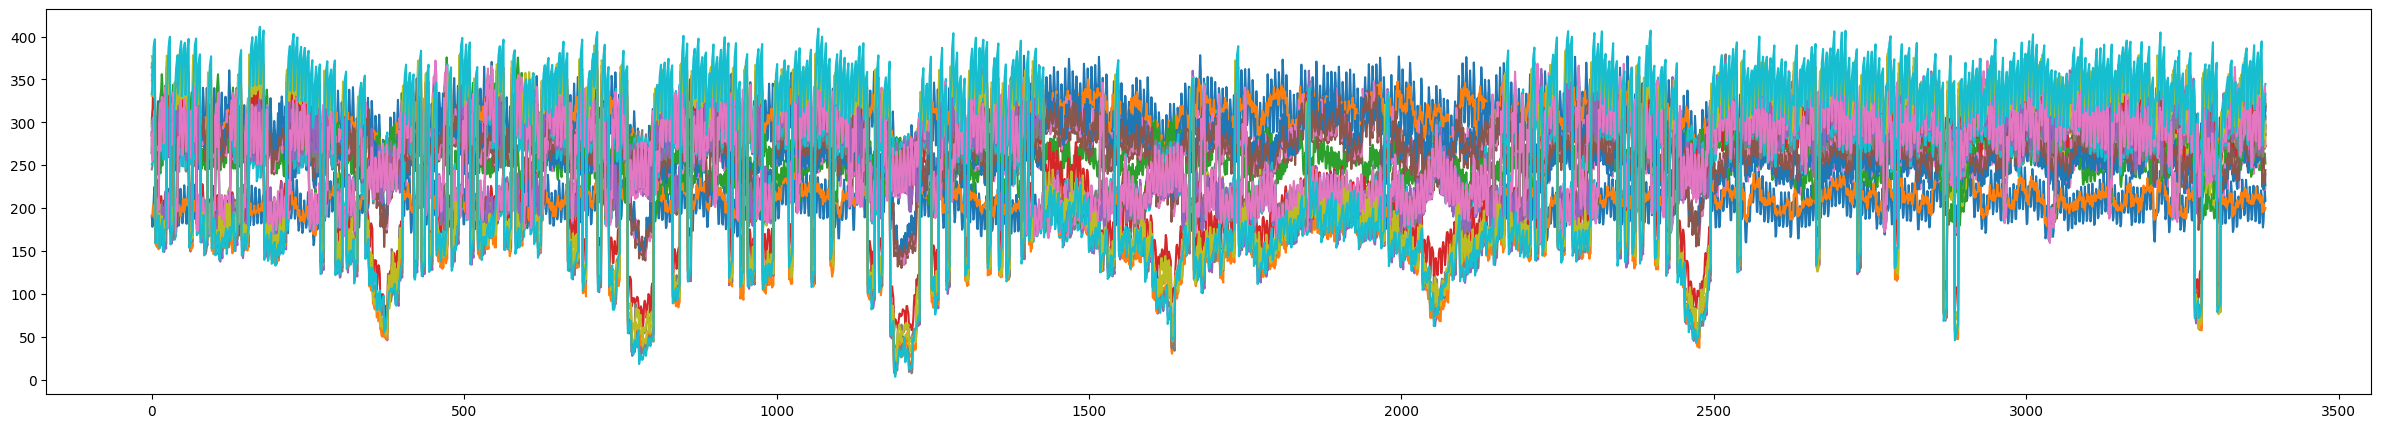

In [10]:
plt.figure(figsize=(30, 5))
plt.plot(g1a1[0].T) 
plt.show()

## 3. Filter

In [7]:
# Butterworth low-pass filter
def butter_lowpass_filter(data, fs, order=4):
    nyquist = fs/2
    cutoff_freq = 120 / nyquist
    b, a = butter(order, cutoff_freq, btype='low')
    return filtfilt(b, a, data)

# Discrete wavelet transform function
def dwt_denoise(data, wavelet, n):
    
    '''
    pywt.wavedec return 1D multilevel fo decomposition of given signal
    [cA_n, cD_n, cD_n-1, ..., cD2, cD1]
    cA_n is approximation coefficients at n-level
    cD_n to cD1 is detail coefficients at different level 
    '''
   
    # Perform wavelet decomposition
    coeffs = pywt.wavedec(data, wavelet,'sym', level=n)
    
    # Use the first level detail coefficients to calculate a threshold
    first_level_detail_coeff = coeffs[-1]  # Detail coefficients at the first level
    th = threshold(first_level_detail_coeff)
    
    # Apply thresholding to all detail coefficients with soft threshold
    coeffs_thresholded = [coeffs[0]] + [pywt.threshold(c, th, mode='soft') for c in coeffs[1:]]
    
    # Reconstruct  the denoised signal
    denoised_amp = pywt.waverec(coeffs_thresholded, wavelet)
    
    return denoised_amp

def threshold(data):
    '''
    Calculate threshold using heuristic variant of 
    the adaptive threshold selection using principle of 
    Stein's Unbiased Risk Estimate.
    '''
    n = len(data)
    th = sqrt(2*log(n))
    
    # get norm of data
    normsqr = np.dot(data.T, data)
    eta = 1.0*(normsqr-n)/n
    crit = (log(n,2)**1.5)*sqrt(n)
    
    if (eta < crit).any(): th = th
    else:
        sx2 = [sx*sx for sx in np.absolute(data)]
        sx2.sort()
        cumsumsx2 = np.cumsum(sx2)
        risks = []
        for i in range(0, n):
            risks.append((n-2*(i+1)+(cumsumsx2[i]+(n-1-i)*sx2[i]))/n)
        mini = np.argmin(risks)
        rth = sqrt(sx2[mini])
        th = min(th, rth)
    
    return th

After selected subcarriers using SNR

sampling rate `fs` 
$$ f_s = \frac{\text{number of samples per frame} \times \text{number of frames}}{\text{video duration}} = \frac{40 \times 370}{14} = 1057.14 Hz \approx 1000 Hz $$

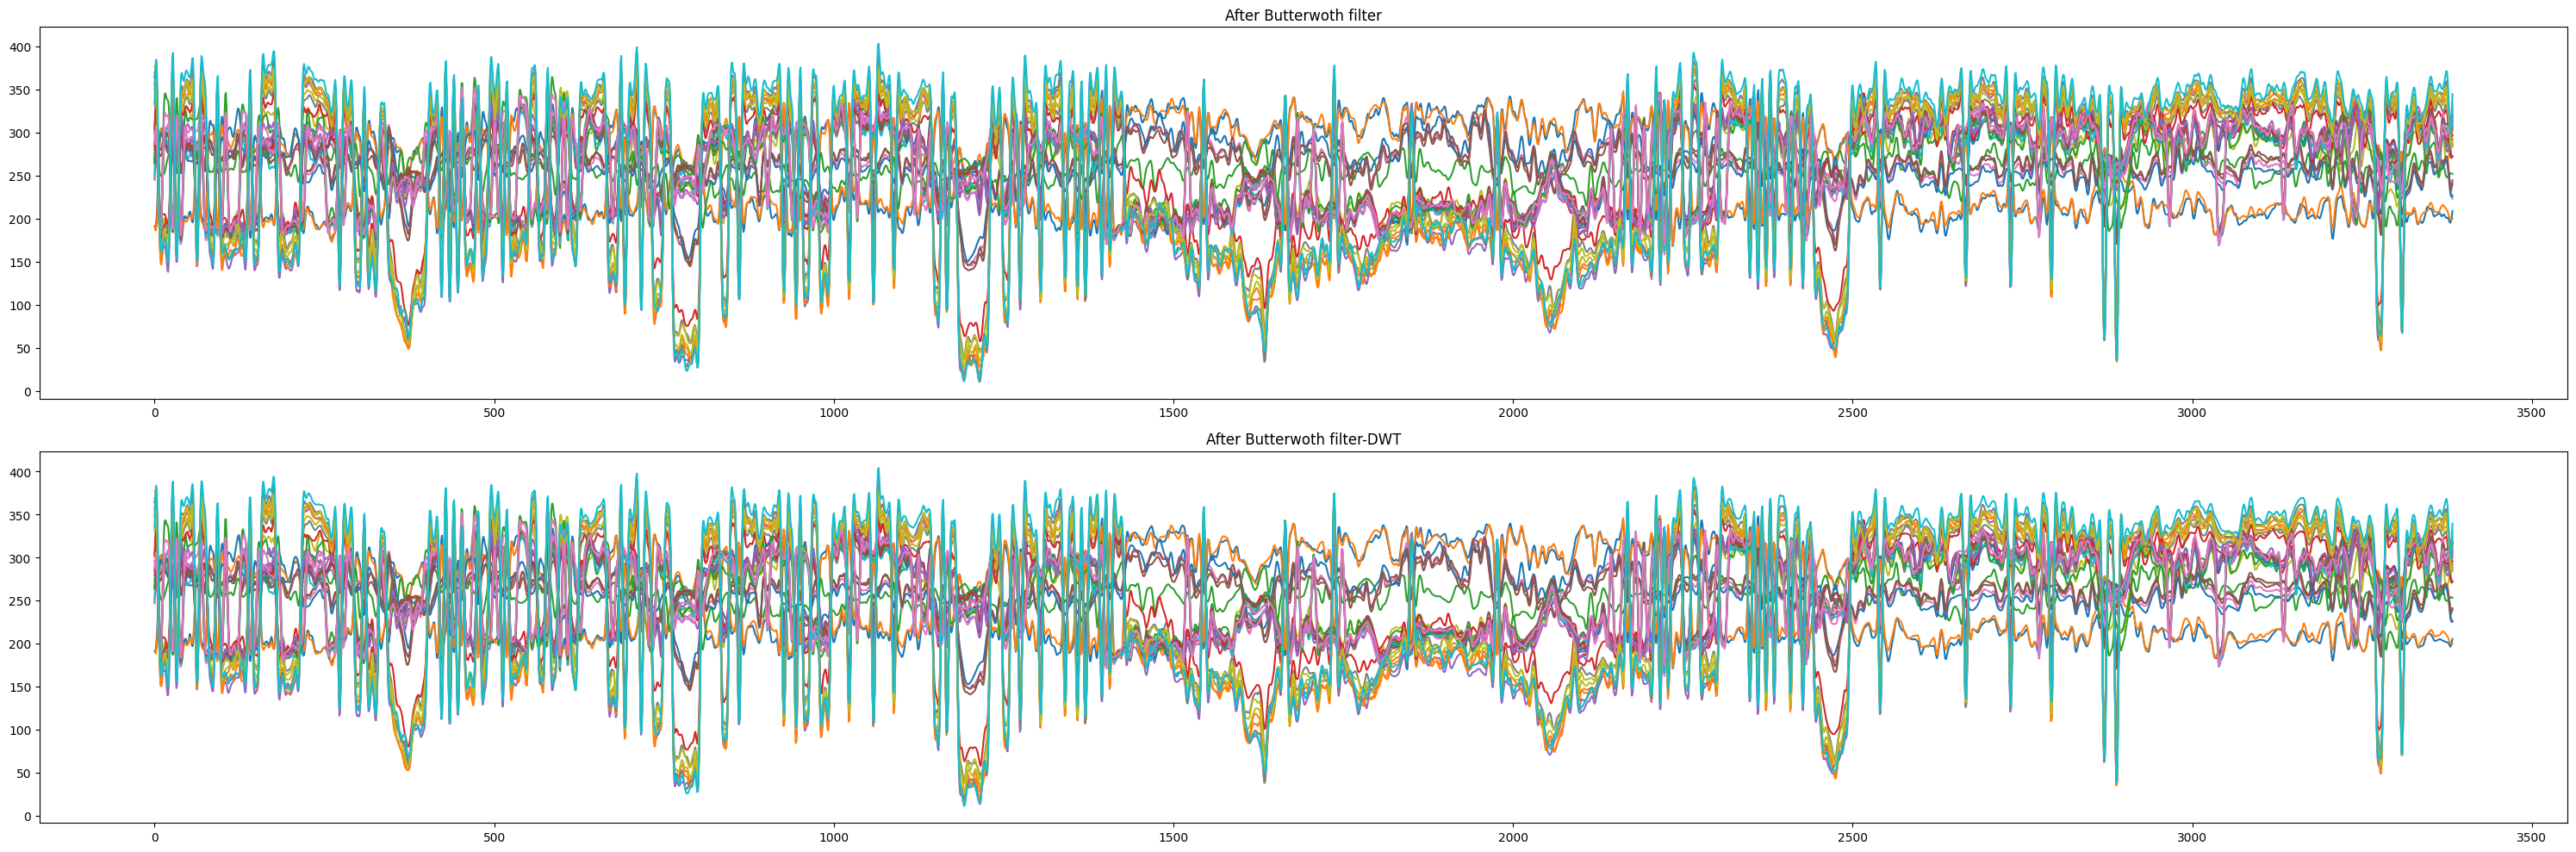

In [13]:
# 30 subcarriers
g1a1_btw = butter_lowpass_filter(g1a1, fs=1000)
g1a1_dwt = []
for i in range(g1a1_btw.shape[0]):
    out = dwt_denoise(g1a1_btw[i], 'sym6', 6)
    g1a1_dwt.append(out)
g1a1_dwt = np.array(g1a1_dwt)

_, axes = plt.subplots(2, 1, figsize=(30, 10))
axes[0].plot(g1a1_btw[0].T)
axes[1].plot(g1a1_dwt[0].T)

axes[0].set_title('After Butterwoth filter')
axes[1].set_title('After Butterwoth filter-DWT')
plt.tight_layout()
plt.show()

# Prepare preprocessed data

In [4]:
def natural_sort_key(file_path):
    """
    Sort key for natural sorting of file paths with numbers.
    """
    return [int(text) if text.isdigit() else text.lower() for text in re.split('([0-9]+)', file_path)]

# Extract frames
def extract_csi_to_frames(denoised_data, original_frame_size):
    frames = []
    total_frames = denoised_data.shape[2]
    
    # Extract full-sized frames
    for start in range(0, total_frames - (total_frames % original_frame_size), original_frame_size):
        end = start + original_frame_size
        frame = denoised_data[:, :, start:end]
        frames.append(frame)

    # Handle the remainder
    remainder = total_frames % original_frame_size
    if remainder > 0:
        start = total_frames - remainder
        frame = denoised_data[:, :, start:]
        frames.append(frame)

    return frames

# Process
def process_files(src_patterns, dest_base_dir, n_sub):
    os.makedirs(dest_base_dir, exist_ok=True)

    for src_pattern in src_patterns:
        matching_files = sorted(glob.glob(src_pattern), key=natural_sort_key)

        file_groups = {}
        for file_path in matching_files:
           
            parts = file_path.split(os.sep)
            group = parts[-3]  # Extract G[]
            action = parts[-2]  # Extract A[]
            group_action = os.path.join(group, action)

            if group_action not in file_groups:
                file_groups[group_action] = []
            file_groups[group_action].append(file_path)

        for group_action, files in file_groups.items():
            try:
                group_data = []
                for file in files:
                    data = np.load(file).reshape(4, 2025, -1)
                    group_data.append(data) # (4, 2025, 6*frames)
                combined_data = np.concatenate(group_data, axis=-1)  # Combine along the last axis 
                
                # remove nan subcarriers
                nan_subcarriers = np.any(np.isnan(combined_data), axis=(0, 2))
                combined_data = combined_data[:, ~nan_subcarriers, :]
               
                # Apply subcarrier selection
                sub_selected = select_subcarriers(combined_data, n_sub)
                
                # Apply denoising
                denoised_data = []
                btw_denoised_data = butter_lowpass_filter(sub_selected, fs=1000)  # n subcarrier selected
                    
                for i in range(btw_denoised_data.shape[0]):
                    dwt_denoise_data = dwt_denoise(btw_denoised_data[i], 'sym6', 6)
                    denoised_data.append(dwt_denoise_data)
                denoised_data = np.array(denoised_data)
                
                # Extract frames back
                original_frame_size = group_data[0].shape[-1]
                frames = extract_csi_to_frames(denoised_data, original_frame_size) # returen shape: (564, 4, 30, 6)
                
                # validate
                # reshaped_frames = frames.transpose(1,2,3,0).reshape(4, 30, -1)  # Reshape frames to (4, 30, n)
                # plt.figure(figsize=(50, 5))
                # plt.plot(reshaped_frames[i].T)  # Plot each subcarrier
                # plt.show()

                # Save each frame
                idx = 0
                for frame_data in frames:
                    dest_group_action = os.path.join(dest_base_dir, group_action)
                    frame_filename = f'frame{idx}.npy'
                    dest_path = os.path.join(dest_group_action, frame_filename)
                    idx += 1
                    os.makedirs(os.path.dirname(dest_path), exist_ok=True)
                    np.save(dest_path, frame_data)
                    print(f"Processed and saved: {dest_path}")
                    
            except Exception as e:
                print(f"Error processing group {group_action}: {e}")

In [ ]:
src = [r'D:\CSKU\NCU\workspace\multi-person-data\CSI\G[1-3]\A[1-3]\*.npy',
    r'D:\CSKU\NCU\workspace\multi-person-data\CSI\G[4-7]\A[1-4]\*.npy']
des = '../multi-person-data/preprocess_csi/30_sub'

# Apply n-selected subcarriers
process_files(src, des, 30)

Test

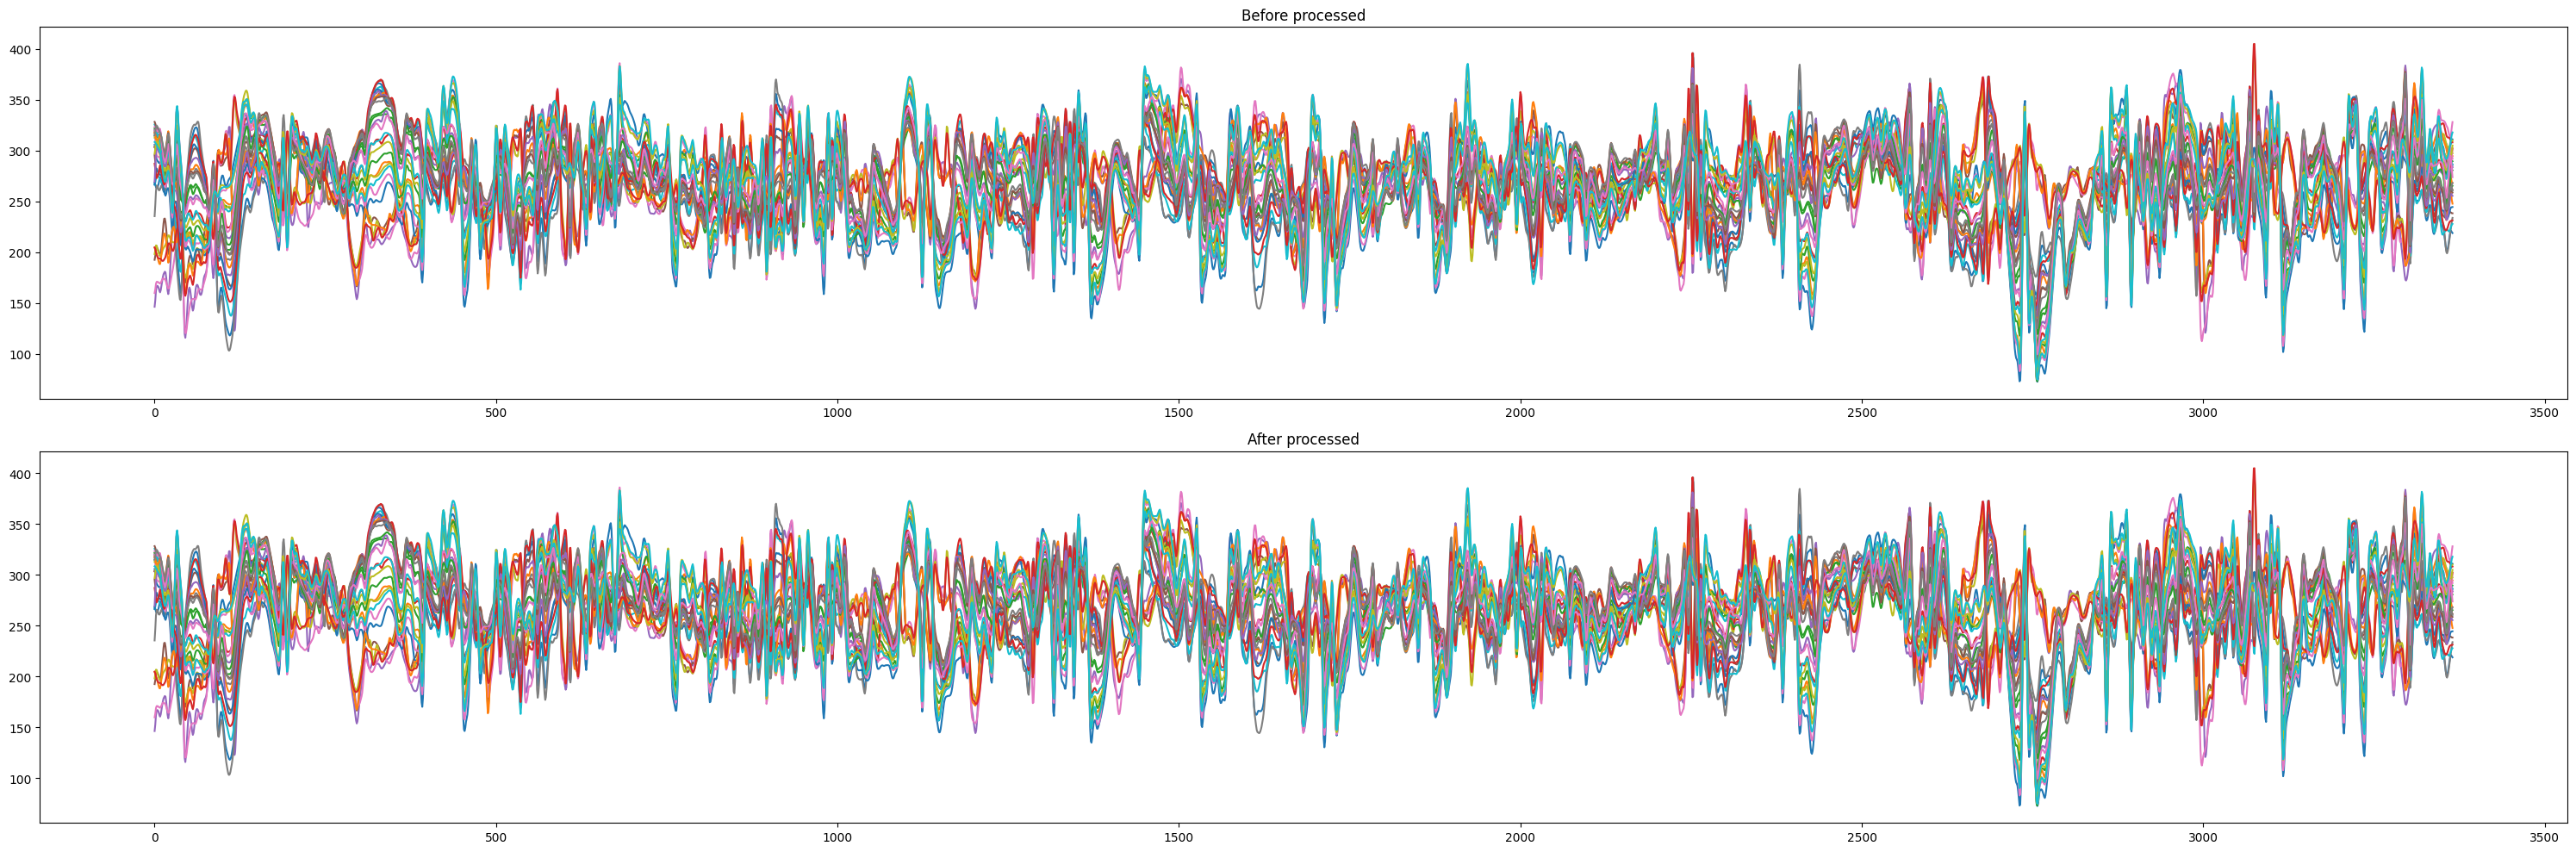

In [17]:
def load_data(path):
    data = []
    files = sorted(os.listdir(path), key=natural_sort_key)
    for file in files:
        a = np.load(os.path.join(path, file), allow_pickle=True).reshape(4,2025,-1).T
        data.append(a)
    data = np.vstack(data).T
    # remove nan subcarriers
    nan_subcarriers = np.any(np.isnan(data), axis=(0, 2))
    data = data[:, ~nan_subcarriers, :]
    return data

def load_new_data(path):
    data = []
    # natural sorted file
    files = sorted(os.listdir(path), key=natural_sort_key)
    for file in files:
        a = np.load(os.path.join(path, file), allow_pickle=True)
        data.append(a)
    data = np.concatenate(data, axis=-1)
    return data

original = load_data('../multi-person-data/CSI/G7/A1')
# 30 subcarriers
original_30 = select_subcarriers(original, 30)
original_btw = butter_lowpass_filter(original_30, fs=1000)
original_dwt = []
for i in range(original_btw.shape[0]):
    out = dwt_denoise(original_btw[i], 'sym6', 6)
    original_dwt.append(out)
original_dwt = np.array(original_dwt)
test = load_new_data('../multi-person-data/preprocess_csi/30_sub/G7/A1')

_, axes = plt.subplots(2, 1, figsize=(30, 10))
axes[0].set_title('Before processed')
axes[0].plot(original_dwt[0][:, :].T)

axes[1].set_title('After processed')
axes[1].plot(test[0][:, :].T)
plt.tight_layout()
plt.show()

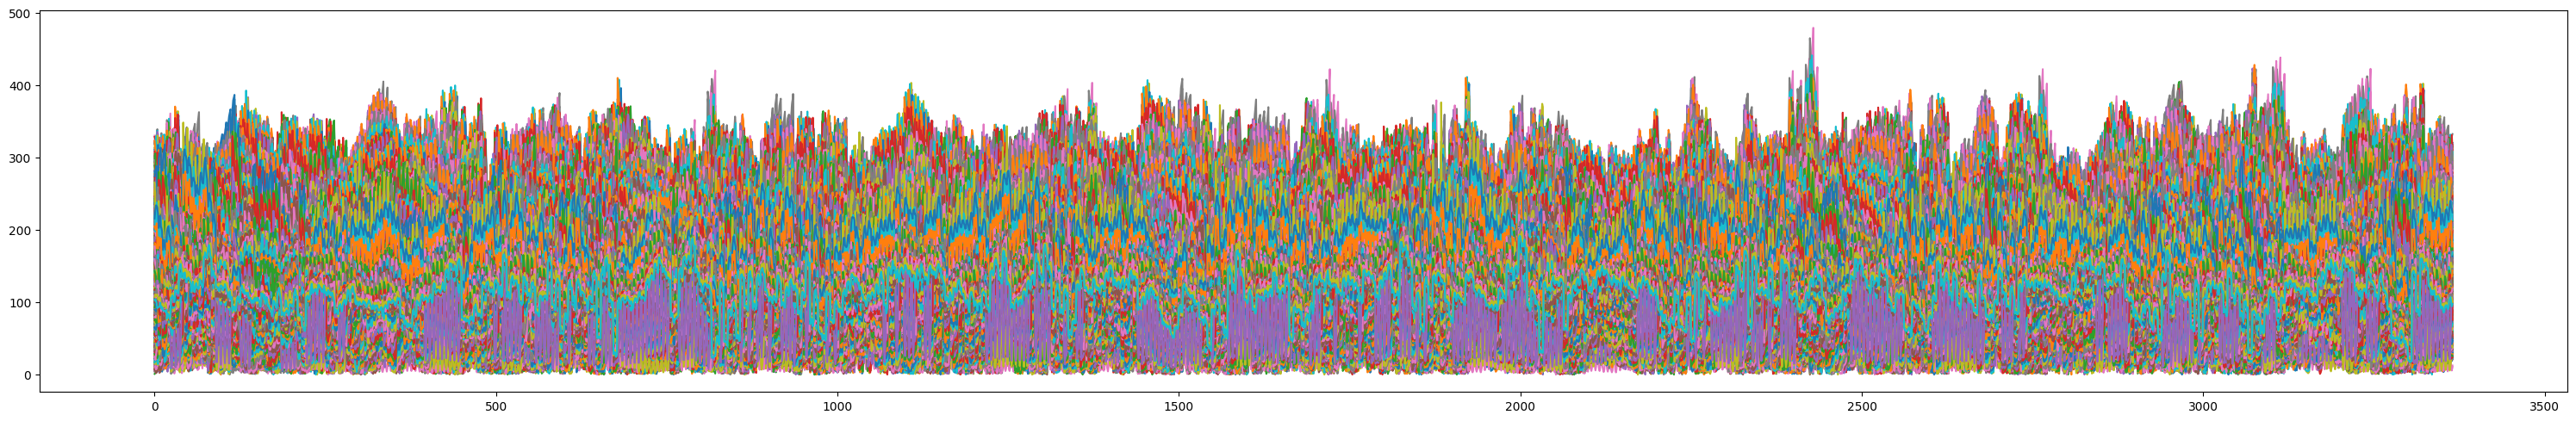

In [18]:
plt.figure(figsize=(30, 5))
plt.plot(original[0][:, :].T)
plt.tight_layout()
plt.show()

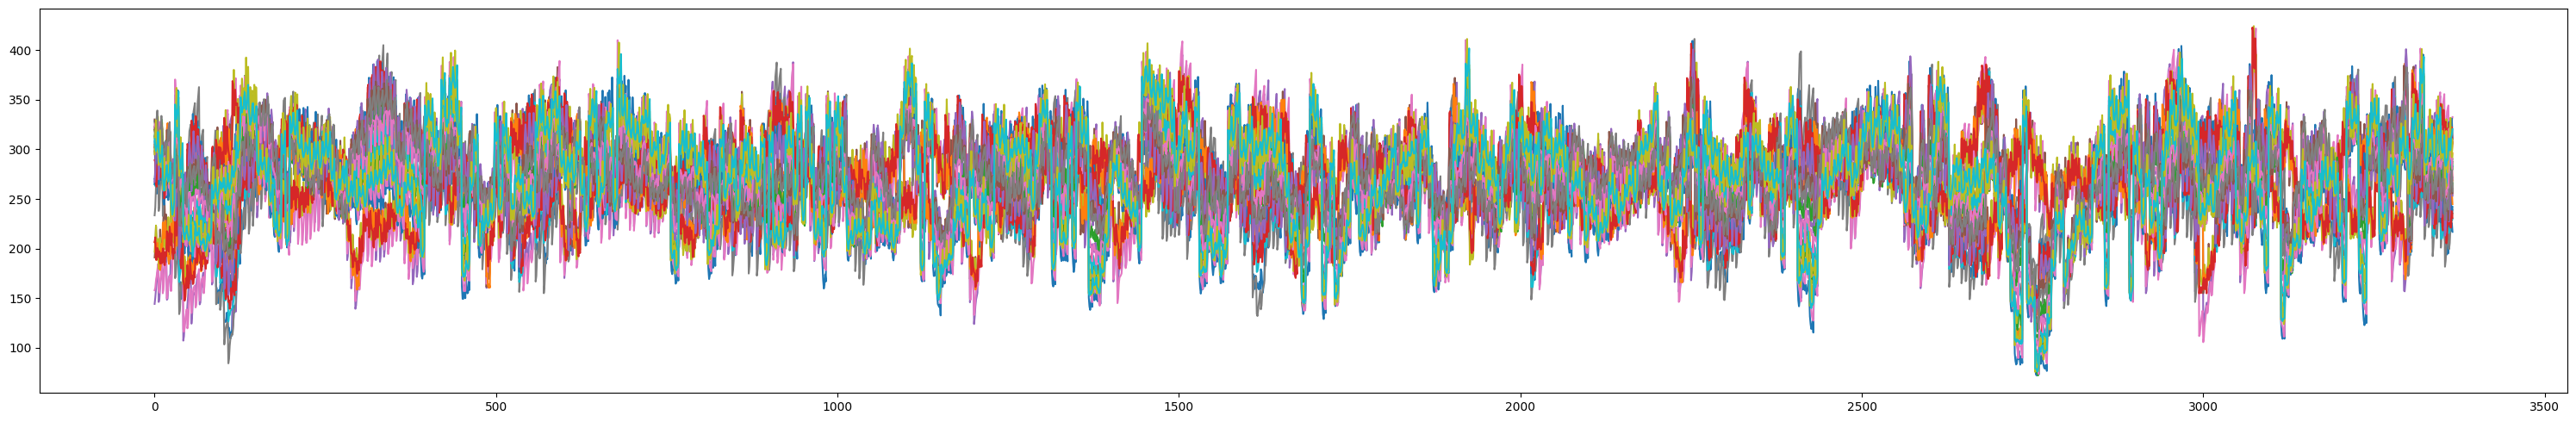

In [19]:
plt.figure(figsize=(30, 5))
plt.plot(original_30[0][:, :].T)
plt.tight_layout()
plt.show()

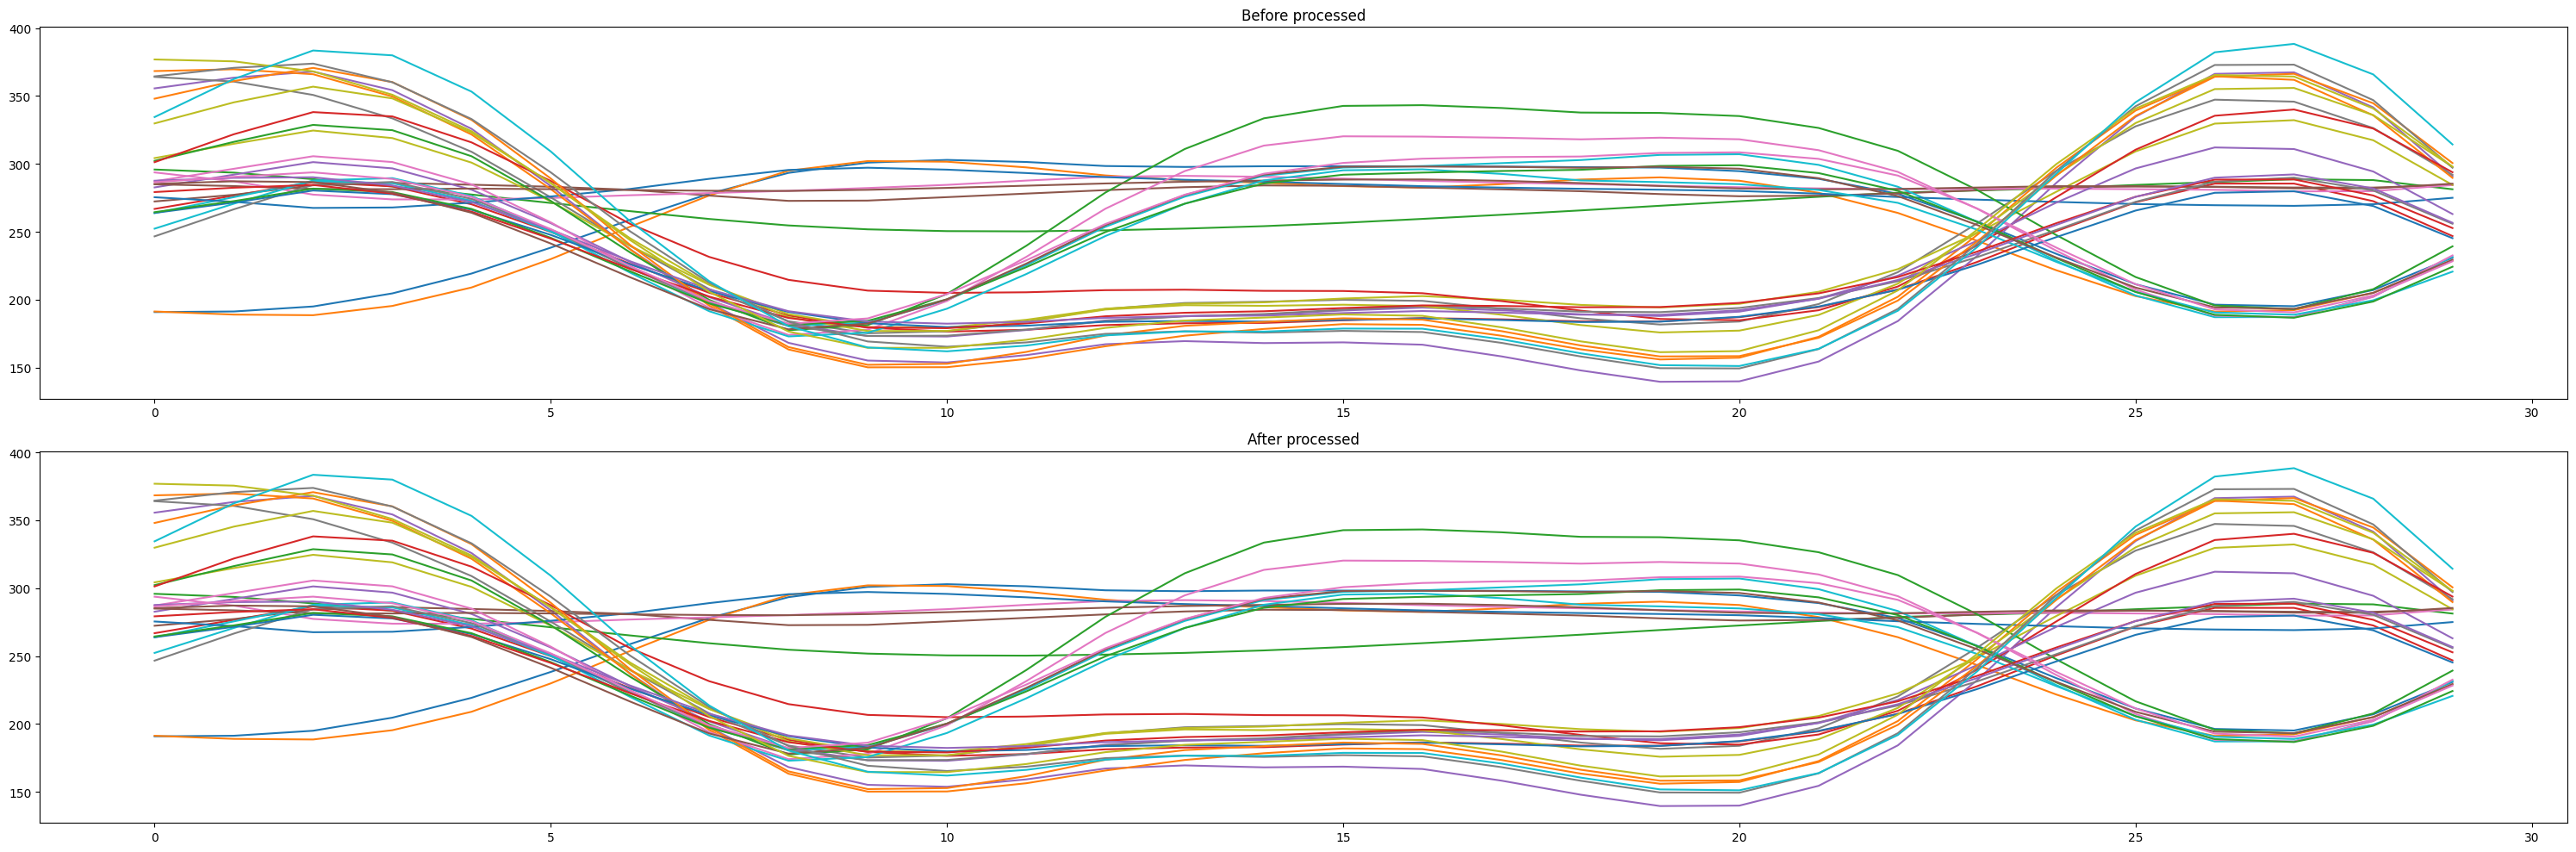

In [19]:
_, axes = plt.subplots(2, 1, figsize=(30, 10))
axes[0].set_title('Before processed')
axes[0].plot(g1a1_dwt[0][:, :30].T)

axes[1].set_title('After processed')
axes[1].plot(test[0][:, :30].T)
plt.tight_layout()
plt.show()

In [ ]:
# # 60 subcarriers
# g1a1_btw = butter_lowpass_filter(g1a1[:,:60,:], fs=1000)
# g1a1_dwt = []
# for i in range(g1a1_btw.shape[0]):
#     out = dwt_denoise(g1a1_btw[i], 'sym6', 6)
#     g1a1_dwt.append(out)
# g1a1_dwt = np.array(g1a1_dwt)

# _, axes = plt.subplots(2, 1, figsize=(30, 10))
# axes[0].plot(g1a1_btw[0][:, :500].T)
# axes[1].plot(g1a1_dwt[0][:, :500].T)
# plt.tight_layout()
# plt.show()

In [ ]:
# # 90 subcarriers
# g1a1_btw = butter_lowpass_filter(g1a1[:,:90,:], fs=1000)
# g1a1_dwt = []
# for i in range(g1a1_btw.shape[0]):
#     out = dwt_denoise(g1a1_btw[i], 'sym6', 6)
#     g1a1_dwt.append(out)
# g1a1_dwt = np.array(g1a1_dwt)

# _, axes = plt.subplots(2, 1, figsize=(30, 10))
# axes[0].plot(g1a1_btw[0][:, :500].T)
# axes[1].plot(g1a1_dwt[0][:, :500].T)
# plt.tight_layout()
# plt.show()

In [ ]:
# # 120 subcarriers
# g1a1_btw = butter_lowpass_filter(g1a1[:,:120,:], fs=1000)
# g1a1_dwt = []
# for i in range(g1a1_btw.shape[0]):
#     out = dwt_denoise(g1a1_btw[i], 'sym6', 6)
#     g1a1_dwt.append(out)
# g1a1_dwt = np.array(g1a1_dwt)

# _, axes = plt.subplots(2, 1, figsize=(30, 10))
# axes[0].plot(g1a1_btw[0][:, :500].T)
# axes[1].plot(g1a1_dwt[0][:, :500].T)
# plt.tight_layout()
# plt.show()